# Heart Disease Prediction: ANN vs Classical Models

This notebook implements an Artificial Neural Network (ANN) for the heart disease prediction task and compares it with classical models (Logistic Regression, Random Forest). 

**Key Goals:**
1.  Use the **same** test set as previous experiments for fair comparison.
2.  Handle class imbalance using **class weights**.
3.  Use a simple, regularized MLP architecture (Dropout + Batch Normalization).
4.  Tune the decision threshold to optimize F1-score for the minority class (Disease).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                            roc_auc_score, confusion_matrix, classification_report, 
                            roc_curve, precision_recall_curve, average_precision_score)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configuration
BASE_DIR = Path.cwd()
DATA_PATH = BASE_DIR / 'dataset' / 'heart_disease.csv'

print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.20.0


## 1. Data Loading and Splitting

We load the data and perform the splits. 
**Crucial Step:** We must replicate the exact Train/Test split used in previous work (80/20) to ensure the Test set is identical.
Then, we further split the Training set into Train (60% of total) and Validation (20% of total) for the ANN.

In [3]:
# Load dataset
df = pd.read_csv(DATA_PATH, na_values=['NA', 'na', 'N/A', 'n/a', ''])

# Clean column names
df.columns = df.columns.str.strip()

# Prepare Target Variable
target_col = 'Heart_ stroke'
df['target'] = (df[target_col].str.lower() == 'yes').astype(int)
df = df.drop(columns=[target_col])

# Define Features
numeric_features = ['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']
categorical_features = ['Gender', 'education', 'currentSmoker', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes']

X = df.drop(columns=['target'])
y = df['target']

# 1. Initial Split: 80% Train_Orig, 20% Test (Same as before)
X_train_orig, X_test, y_train_orig, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 2. Secondary Split for ANN: Split the 80% Train_Orig into 75% Train (60% total) and 25% Val (20% total)
X_train, X_val, y_train, y_val = train_test_split(X_train_orig, y_train_orig, test_size=0.25, random_state=42, stratify=y_train_orig)

print(f"Original Training Set: {X_train_orig.shape} (Used for Classical Models)")
print(f"ANN Training Set:      {X_train.shape} (60%)")
print(f"ANN Validation Set:    {X_val.shape}   (20%)")
print(f"Test Set:              {X_test.shape}  (20% - Fixed)")

Original Training Set: (3390, 15) (Used for Classical Models)
ANN Training Set:      (2542, 15) (60%)
ANN Validation Set:    (848, 15)   (20%)
Test Set:              (848, 15)  (20% - Fixed)


## 2. Preprocessing

We use the same preprocessing pipeline as before:
- **Numeric**: Median imputation + Standard Scaling
- **Categorical**: Most frequent imputation + One-Hot Encoding

In [4]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Fit on the ANN Training set (to avoid data leakage)
preprocessor.fit(X_train)

# Transform all sets
X_train_proc = preprocessor.transform(X_train)
X_val_proc = preprocessor.transform(X_val)
X_test_proc = preprocessor.transform(X_test)

# Also transform the full original training set for classical models
X_train_orig_proc = preprocessor.transform(X_train_orig)

print(f"Processed Train Shape: {X_train_proc.shape}")

Processed Train Shape: (2542, 17)


## 3. Handle Class Imbalance

We compute class weights to pass to the ANN during training. This ensures the model pays more attention to the minority class.

In [5]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))

print(f"Class Weights: {class_weight_dict}")

Class Weights: {0: 0.589517625231911, 1: 3.2927461139896375}


## 4. Build ANN Model

Architecture:
- Input Layer
- Dense(64, ReLU) -> BatchNorm -> Dropout(0.3)
- Dense(32, ReLU) -> BatchNorm -> Dropout(0.3)
- Output(1, Sigmoid)

In [6]:
def build_ann(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_dim,)),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

model = build_ann(X_train_proc.shape[1])
model.summary()

c:\Users\salla\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,649 (14.25 KB)

 Trainable params: 3,457 (13.50 KB)

 Non-trainable params: 192 (768.00 B)

## 5. Train ANN

We use Early Stopping to prevent overfitting.

In [10]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=40,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    X_train_proc, y_train,
    validation_data=(X_val_proc, y_val),
    epochs=200,
    batch_size=64,
    class_weight=class_weight_dict,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7010 - loss: 0.5749 - val_accuracy: 0.6792 - val_loss: 0.5850
Epoch 2/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.7014 - loss: 0.5661 - val_accuracy: 0.6840 - val_loss: 0.5862
Epoch 3/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6884 - loss: 0.5732 - val_accuracy: 0.6745 - val_loss: 0.5873
Epoch 4/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7002 - loss: 0.5593 - val_accuracy: 0.6828 - val_loss: 0.5824
Epoch 5/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6983 - loss: 0.5645 - val_accuracy: 0.6816 - val_loss: 0.5787
Epoch 6/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6900 - loss: 0.5735 - val_accuracy: 0.6851 - val_loss: 0.5837
Epoch 7/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6908 - loss: 0.5782 - val_accuracy: 0.6757 - val_loss: 0.5912
Epoch 8/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6853 - loss: 0.5676 - val_accuracy: 0.

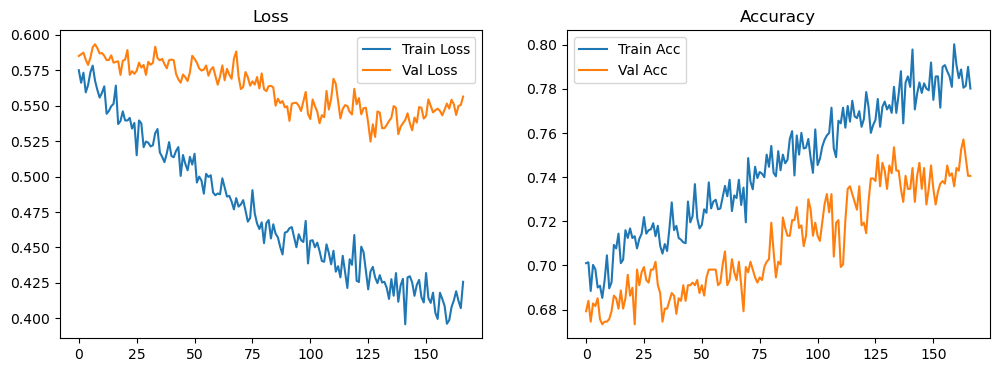

In [11]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()
plt.show()

## 6. Evaluation and Threshold Tuning

We predict probabilities on the Test set and tune the threshold to maximize F1-score for the positive class.

In [12]:
y_pred_proba_ann = model.predict(X_test_proc).flatten()

def tune_threshold(y_true, y_proba, name="Model"):
    thresholds = np.arange(0.1, 0.91, 0.01)
    best_f1 = 0
    best_thresh = 0.5
    
    f1_scores = []
    
    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)
        f1 = f1_score(y_true, y_pred, pos_label=1)
        f1_scores.append(f1)
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = t
            
    print(f"--- {name} ---")
    print(f"Best Threshold: {best_thresh:.2f}")
    print(f"Best F1 Score: {best_f1:.4f}")
    
    # Evaluate at best threshold
    y_pred_best = (y_proba >= best_thresh).astype(int)
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred_best))
    
    roc_auc = roc_auc_score(y_true, y_proba)
    pr_auc = average_precision_score(y_true, y_proba)
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"PR-AUC:  {pr_auc:.4f}")
    
    return {
        'Model': name,
        'Best Threshold': best_thresh,
        'Precision': precision_score(y_true, y_pred_best),
        'Recall': recall_score(y_true, y_pred_best),
        'F1': best_f1,
        'ROC-AUC': roc_auc,
        'PR-AUC': pr_auc
    }

ann_results = tune_threshold(y_test, y_pred_proba_ann, "ANN")

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
--- ANN ---
Best Threshold: 0.23
Best F1 Score: 0.3069

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.50      0.64       719
           1       0.20      0.69      0.31       129

    accuracy                           0.53       848
   macro avg       0.55      0.59      0.47       848
weighted avg       0.79      0.53      0.59       848

ROC-AUC: 0.6204
PR-AUC:  0.2345


## 7. Comparison with Classical Models

We re-train Logistic Regression and Random Forest (Balanced) on the **full original training set (80%)** to give them the best possible performance, and evaluate them on the same Test set.

In [ ]:
# 1. Logistic Regression (Balanced)
lr_model = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
lr_model.fit(X_train_orig_proc, y_train_orig)
y_prob_lr = lr_model.predict_proba(X_test_proc)[:, 1]
lr_results = tune_threshold(y_test, y_prob_lr, "Logistic Regression (Balanced)")

# 2. Random Forest (Balanced)
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42, n_estimators=100)
rf_model.fit(X_train_orig_proc, y_train_orig)
y_prob_rf = rf_model.predict_proba(X_test_proc)[:, 1]
rf_results = tune_threshold(y_test, y_prob_rf, "Random Forest (Balanced)")

## 8. Final Comparison Table

In [ ]:
comparison_df = pd.DataFrame([lr_results, rf_results, ann_results])
comparison_df = comparison_df.set_index('Model')
comparison_df

## Conclusion

**Analysis of Results:**
- **Precision/Recall Trade-off:** Look at the table above. Does the ANN achieve a better balance than LR/RF?
- **ROC-AUC / PR-AUC:** These metrics are threshold-independent. If ANN is higher, it has better ranking ability.

*Note: If the ANN performs similarly to Logistic Regression, it suggests the problem is likely linear or the features don't contain complex non-linear interactions that a small MLP can exploit better than a linear model.*